In [99]:
# Uploading the packages we'll need
import os
from zipfile import ZipFile
import pickle
import bz2
import json

import numpy.testing as npt

import pandas as pd
import numpy as np

import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt


In [100]:
# expected file paths
DATA_ROOT_DIRECTORY: str = 'data'
COMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'compressed')
COMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_manifest.pbz2')
COMPRESSED_IMAGES_FILE_PATH: str = os.path.join(COMPRESSED_DATA_DIRECTORY_PATH, 'shipnet_images.zip')

# file paths to createhttp://localhost:8888/notebooks/Documents/EN213_final/EM213-Final_Project-dev-kms/Ship%20Analysis.ipynb
UNCOMPRESSED_DATA_DIRECTORY_PATH: str = os.path.join(DATA_ROOT_DIRECTORY, 'uncompressed')
UNCOMPRESSED_MANIFEST_FILE_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet.json')
UNCOMPRESSED_IMAGES_DIRECTORY_PATH: str = os.path.join(UNCOMPRESSED_DATA_DIRECTORY_PATH, 'shipnet')
    
def get_full_path(local_path: str):
    """
    Gets the full path from the local path.

    :param local_path: a string pointing to a path local to this Notebook
    :returns: a string pointing to the full path corresponding to the provided local path
    """
    return os.path.join(os.getcwd(), local_path)

def raise_file_not_found_error_for_path(expected_object: str, local_path: str):
    """
    Raises a descriptive file not found error using the provided

    :param expected_object: a string fragment describing the content of the expected file
    :param local_path: the path that was not found
    :return: None.
    :raises FileNotFoundError
    """
    raise FileNotFoundError(f'Could not find {expected_object} at the specified path: {get_full_path(local_path)}')

In [101]:
def deflate_manifest():
    """
    Deflates the compressed manifest file using bz2 decompression. Note this will create a ~350 MB file in the
    UNCOMPRESSED_DATA_DIRECTORY_PATH.

    :return: None.
    """
    with bz2.BZ2File(COMPRESSED_MANIFEST_FILE_PATH, 'rb') as input_file:
        with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'w') as output_file:
            json.dump(pickle.load(input_file), output_file)
    return None


def deflate_images():
    """
    Deflates the compressed images file using zip decompression. Note this will create 4000 images in the
    UNCOMPRESSED_IMAGES_DIRECTORY_PATH directory.

    :return: None.
    """
    with ZipFile(COMPRESSED_IMAGES_FILE_PATH, 'r') as input_file:
        input_file.extractall(UNCOMPRESSED_IMAGES_DIRECTORY_PATH)
    return None


def check_and_deflate_all():
    """
    Checks for expected input files and a non-existent UNCOMPRESSED_DATA_DIRECTORY_PATH directory, then
    deflates the manifest and images. 

    :raises FileNotFoundError if expected input files are not found
    :raises FileExistsError if UNCOMPRESSED_DATA_DIRECTORY_PATH exists
    :returns: None.
    """

    # check if compressed data directory exists
    if os.path.isdir(COMPRESSED_DATA_DIRECTORY_PATH):

        # if so, check for compressed manifest file
        if not os.path.isfile(COMPRESSED_MANIFEST_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed manifest file', COMPRESSED_MANIFEST_FILE_PATH)

        # and compressed images file
        if not os.path.isfile(COMPRESSED_IMAGES_FILE_PATH):
            raise_file_not_found_error_for_path('the compressed images file', COMPRESSED_IMAGES_FILE_PATH)

    else:
        raise raise_file_not_found_error_for_path('the compressed data directory', COMPRESSED_DATA_DIRECTORY_PATH)

    # check if uncompressed data directory exists
    if os.path.isdir(UNCOMPRESSED_DATA_DIRECTORY_PATH):
        raise FileExistsError(('The path to the output directory already exists: '
                               f'{get_full_path(UNCOMPRESSED_DATA_DIRECTORY_PATH)}. If you are sure you want to run this step '
                               'please remove this directory manually - we will not overwrite it.'))

    # inflate files
    else:
        os.mkdir(UNCOMPRESSED_DATA_DIRECTORY_PATH)
        deflate_manifest()
        deflate_images()

    return None

In [102]:
check_and_deflate_all()

FileExistsError: The path to the output directory already exists: /home/colinalejo/Documents/EN213_final/KERAS (98.3)/data/uncompressed. If you are sure you want to run this step please remove this directory manually - we will not overwrite it.

In [103]:
# read in the manifest
with open(UNCOMPRESSED_MANIFEST_FILE_PATH, 'r') as f:
    dataset = json.load(f)



In [104]:
# Turning the json information into a numpy array and then assign it as our X and y values

X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

# Identifying the class names

class_names = ['Not A Ship', 'Ship']

# Checking the amount of ship and not a ship labels for the images

pd.Series(y).value_counts()

0    3000
1    1000
dtype: int64

In [105]:
X_reshaped = X.reshape([-1, 3, 80, 80])
X_reshaped = X.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
y_reshaped = to_categorical(y, num_classes=2)
#normlaize
X_reshaped = X_reshaped / 255


In [106]:
y_reshaped.shape

(4000, 2)

In [107]:
# Doing the initial train/test split on the reshaped values
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.20, random_state=42)

# Creating the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)




In [108]:


X_test.shape



(800, 80, 80, 3)

In [109]:
# Using Sequential and then adding the layers after
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])



In [110]:
# Training the model

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))



Train on 2400 samples, validate on 800 samples
Epoch 1/20
2400/2400 [==============================] - ETA: 0s - loss: 0.9614 - acc: 0.7733

/opt/anaconda/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2400/2400 [==============================] - 2s 780us/sample - loss: 0.9614 - acc: 0.7733 - val_loss: 0.3843 - val_acc: 0.8325
Epoch 2/20
2400/2400 [==============================] - 2s 656us/sample - loss: 0.3474 - acc: 0.8679 - val_loss: 0.3494 - val_acc: 0.8562
Epoch 3/20
2400/2400 [==============================] - 2s 639us/sample - loss: 0.3656 - acc: 0.8596 - val_loss: 0.3015 - val_acc: 0.8763
Epoch 4/20
2400/2400 [==============================] - 2s 630us/sample - loss: 0.3678 - acc: 0.8558 - val_loss: 0.2601 - val_acc: 0.8988
Epoch 5/20
2400/2400 [==============================] - 1s 616us/sample - loss: 0.2697 - acc: 0.8938 - val_loss: 0.2531 - val_acc: 0.8913
Epoch 6/20
2400/2400 [==============================] - 1s 621us/sample - loss: 0.2975 - acc: 0.8875 - val_loss: 0.2377 - val_acc: 0.9075
Epoch 7/20
2400/2400 [==============================] - 1s 617us/sample - loss: 0.2567 - acc: 0.9033 - val_loss: 0.2474 - val_acc: 0.9025
Epoch 8/20
2400/2400 [=======================

In [111]:


# Finding our final accuracy on the test set

model.evaluate(X_test, y_test)



[0.343602300286293, 0.86125]

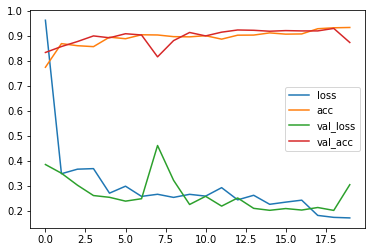

In [112]:
# Plotting the loss and accuracy

pd.DataFrame(history.history).plot();

## Other

In [113]:
# Using a 5x5 kernel and a pooling size of 3x3 at the start of the sequence

# Increasing the number of nodes in the first convolution layer 

# Increasing the pool size in the first pool layer

# Adding an extra convolutional layer + drop out layers to prevent over fitting

# Adding an extra dense layer of 50 neurons towards the end

# Increasing the epochs to 50

# Setting my computer on fire

model2 = Sequential()
model2.add(Conv2D(64, (5, 5), input_shape=(80, 80, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Dropout(0.25))
model2.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(2, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Training the model

history2 = model2.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))



Train on 2400 samples, validate on 800 samples
Epoch 1/50
2400/2400 [==============================] - ETA: 0s - loss: 0.5138 - acc: 0.7675

/opt/anaconda/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2400/2400 [==============================] - 11s 4ms/sample - loss: 0.5138 - acc: 0.7675 - val_loss: 0.3576 - val_acc: 0.8650
Epoch 2/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.3101 - acc: 0.8708 - val_loss: 0.2799 - val_acc: 0.8975
Epoch 3/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.2260 - acc: 0.9042 - val_loss: 0.2115 - val_acc: 0.9175
Epoch 4/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.1972 - acc: 0.9154 - val_loss: 0.2075 - val_acc: 0.9212
Epoch 5/50
2400/2400 [==============================] - 10s 4ms/sample - loss: 0.1803 - acc: 0.9267 - val_loss: 0.1590 - val_acc: 0.9488
Epoch 6/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.1432 - acc: 0.9450 - val_loss: 0.1709 - val_acc: 0.9450
Epoch 7/50
2400/2400 [==============================] - 9s 4ms/sample - loss: 0.1310 - acc: 0.9479 - val_loss: 0.1381 - val_acc: 0.9563
Epoch 8/50
2400/2400 [==============================] - 9

In [114]:


# Finding our final accuracy on the test set

model2.evaluate(X_test, y_test)


[0.11464064531493932, 0.9775]

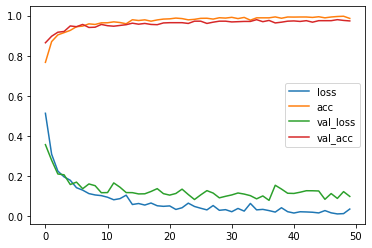

In [115]:
# Plotting the loss and accuracy

pd.DataFrame(history2.history).plot();

In [116]:


model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu'))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

# model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(2, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])

history3 = model3.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val)) #change epoch to 22

Train on 2400 samples, validate on 800 samples
Epoch 1/50
2400/2400 [==============================] - ETA: 0s - loss: 0.3970 - acc: 0.8346

/opt/anaconda/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


2400/2400 [==============================] - 27s 11ms/sample - loss: 0.3970 - acc: 0.8346 - val_loss: 0.2442 - val_acc: 0.9000
Epoch 2/50
2400/2400 [==============================] - 28s 12ms/sample - loss: 0.1987 - acc: 0.9192 - val_loss: 0.1522 - val_acc: 0.9438
Epoch 3/50
2400/2400 [==============================] - 27s 11ms/sample - loss: 0.1273 - acc: 0.9517 - val_loss: 0.1054 - val_acc: 0.9600
Epoch 4/50
2400/2400 [==============================] - 26s 11ms/sample - loss: 0.0820 - acc: 0.9712 - val_loss: 0.1143 - val_acc: 0.9563
Epoch 5/50
2400/2400 [==============================] - 28s 12ms/sample - loss: 0.0764 - acc: 0.9733 - val_loss: 0.0785 - val_acc: 0.9675
Epoch 6/50
2400/2400 [==============================] - 26s 11ms/sample - loss: 0.0742 - acc: 0.9758 - val_loss: 0.1622 - val_acc: 0.9538
Epoch 7/50
2400/2400 [==============================] - 27s 11ms/sample - loss: 0.0492 - acc: 0.9842 - val_loss: 0.1039 - val_acc: 0.9650
Epoch 8/50
2400/2400 [=======================

In [117]:
model3.evaluate(X_test, y_test)

[0.13681300118047715, 0.98375]

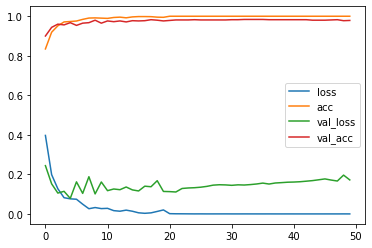

In [118]:
# Plotting the loss and accuracy

pd.DataFrame(history3.history).plot();

In [ ]:
model2.save('path/to/location')

In [ ]:
model3.save('path/to/location')